# Lecture 18: The Seismic Cycle II: Earthquake triggering
## GEO 371T/391: Earthquakes
### Prof. Daniel Trugman, 2021

In [1]:
### Import General Python Packages

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8

# Overview

Earthquake ruptures cause large-scale redistribution of stresses through the crust (and sometimes, the upper mantle). These stress changes can push near-critical faults toward failure, triggering more earthquakes. The stress transfer processes underlying earthquake triggering are the primary cause of the clustering statistics of earthquakes, which "move in packs" that are clustered in space and time. Earthquake triggering is a rather generic concept that encompasses a number of distinct physical processes. In the near field of a large rupture, permanent and static stress changes are often sufficiently large to trigger tens of thousands of detectable aftershocks. At greater distances, transient dynamic stresses can sometimes trigger events. Postseismic deformation, including afterslip, viscoelastic relaxation, and poroelastic mechanisms, may also play an important role under certain circumstances. Moreover, the notion of "triggering" is not limited to earthquake-earthquake interactions, but also may be used to describe extrinsic forcings driving earthquake occurrence, such as anthropogenic activity.

In this notebook, we will explore some of these topics in greater detail. We will see how we can use dislocation model solutions to compute the static stress change tensor for a given fault model, and link this to the concept of Coulomb stress. We will study the duration of aftershock sequences, and see how these can be related to background stressing rates. Finally, we will see how we can use recorded peak ground velocity to measure dynamic strain, which allows for a spatial comparison with the static stress field.

## Example 1: Static Stresses from Okada Dislocations

In a previous lecture, we saw how we could use the formulation of Okada [1992] to compute the displacement field from a dislocation source. We can use the same basic framework to compute the strain field and, assuming linear elasticity, we can compute the stress field from there.

This example walks you through how this might be done. For example, consider a square rupture [why not a circle?] with moment magnitude 2 and stress drop 3 MPa. We will place the source and observation depth at 8km. (Doesn't really matter here). 

For simplicity, we will focus on the maximum shear stress:

\begin{equation}
\tau_{max} = (S_1 + S_3)/2,
\end{equation}

where $S_1$ and $S_3$ are the maximum and minimum shear principal stresses.

In [2]:
### Compute shear stress from a square rupture

# import this package
from okada_wrapper import dc3dwrapper

# source parameters
mag = 2.0 # magnitude
delsig = 3.e6 # stress drop, Pa
mu = 3.e10 # shear modulus, Pa
lam = mu # lame parameter
source_depth = 8000. # fault depth, meters - here more positive is deeper
dip = 90. # fault dip, degrees
rake = -180. # 0 = left-lateral, 90 = reverse, 180 = right-lateral, -90 = normal

# define domain size (m)
xmin, xmax = -800., 800.
npts = 401

# compute moment in N-m (Aki and Richards, 2002)
moment = 10.**(1.5*mag+9.1)

# compute fault length, meters (square rupture) - see Gomberg et al., 2016
length = (3*np.pi/16 * moment/delsig)**(1./3.)
print("M{:}, length = {:.1f}m".format(mag,length))

# compute fault slip, meters
slip = moment / (mu*length**2);

# alpha parameter
alpha = (lam + mu) / (lam + 2*mu);

# dislocation vector
dislocation = slip*np.array(
    [np.cos(rake*(np.pi/180.)),
     np.sin(rake*(np.pi/180.)),
    0])

# observation depth
obs_depth = source_depth

# define grid to make calculations
x = np.linspace(xmin, xmax, npts)
y = np.linspace(xmin, xmax, npts)
ux = np.zeros((npts, npts))
uy = np.zeros((npts, npts))
uz = np.zeros((npts, npts))

# maximum shear stress
shear_grid = np.zeros((npts, npts))

# loop over grid
print("Calculating, please wait...")
for i in range(npts):
    
    # track progress
    if np.mod(i+1,100)==0:
        print("Done with point %d/%d" %(i+1,npts-1))
    
    # inner grid
    for j in range(npts):

        # calculate strain
        success, _, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the observation depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-length/2., length/2.], [-length/2., length/2.], # a square dislocation
            dislocation)          # strike-slip

        # check to see it worked
        assert(success == 0)
        
        # strain tensor
        strain = 0.5*(grad_u + grad_u.T)
               
        # Hooke's law gives the stress tensor
        stress = lam*np.sum(np.diag(strain))*np.eye(3) + 2*mu*strain
        
        # get principal stresses
        sigmas = np.linalg.eigvals(stress);
        S1, S2, S3 = sigmas[0], sigmas[1], sigmas[2]
        
        # max shear in kPa
        shear_grid[i,j] = np.abs(S1-S3)/ 2 / 1.e3;
        
print("Done with all calculations")

ModuleNotFoundError: No module named 'okada_wrapper'

---

You can see that under these assumptions, a M2 event has a fault length of about 60m.

It is instructive to plot fault-parallel and fault-perpindicular cross-sections to see how stress evolves with distance:

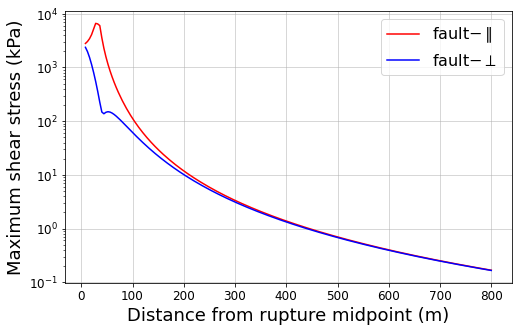

In [3]:
### Plot cross section

# find center of the rupture
imid = 1 + int((npts-1)/2)

# figure setup
fig, axi = plt.subplots(figsize=(8,5))

# plot cross-section
axi.semilogy(x[imid+1:],shear_grid[imid+1:,imid],'-r',label="fault$-\parallel$")
axi.semilogy(x[imid+1:],shear_grid[imid,imid+1:],'-b',label="fault$-\perp$")

# formatting
axi.set_xlabel('Distance from rupture midpoint (m)',fontsize=18);
axi.set_ylabel('Maximum shear stress (kPa)', fontsize=18)
axi.grid(lw=0.5)
axi.tick_params(labelsize=12)
axi.legend(loc="upper right",fontsize=16)

# show results
plt.show()
plt.close()

---

You can see clearly how the stresses decay with distance from the rupture plane.

**Question**: Why is the fault-parallel stress curve different than fault-perpendicular?

Observational studies suggest that stresses need to be greater than ~ 10 kPa in order to trigger earthquakes (e.g. Harris, 1998 and the references therein). Here, 10 kPa comes at a distance of about 200 m from the rupture plane. So 3-4 fault lengths. That is a good rule of thumb for the regime where static stresses may be important.

## Example 2: Aftershock Duration and Stressing Rates

In the rate-and-state seismicity model, changes in stress drive changes in earthquake rates by moving a population of hypothetical earthquake sources toward failure.

The seismicity rate $R$ depends on the background rate $r$, background stressing rate $\dot{S}_0$, and a state variable $\gamma$:

\begin{equation}
R = \frac{r_0}{\gamma \dot{S}_0},
\end{equation}

where state evolves with time $t$ and stress $S$:
\begin{equation}
d \gamma = \frac{1}{a \sigma} \left [ dt - \gamma dS \right].
\end{equation}

Here $a$ is a rate-state parameter and $\sigma$ is the normal stress, assumed constant for this exercise.

Notice that for constant stress, state evolves linearly with time:

\begin{equation}
\gamma = \gamma_0 + \frac{t}{a \sigma}
\end{equation}

---

Following an abrupt stress step, $\Delta S$ (e.g., an earthquake), $dt \approx 0$ and we have

\begin{equation}
\frac{d \gamma}{\gamma} = \frac{- \Delta S}{a \sigma}
\end{equation}

State therefore adjusts instantaneously to a value

\begin{equation}
\gamma = \gamma_0 \exp(-\Delta S / a \sigma).
\end{equation}

And then evolves linearly with time (approximately, neglecting $dS$ for now):

\begin{equation}
\gamma(t) = \gamma_0 \exp(-\Delta S / a \sigma) + \frac{t}{a \sigma}
\end{equation}

---

If $R = r_0$ at $t = 0$, then $\gamma_0 = 1 / \dot{S}_0$.

After our stress step, the seismicity rate therefore has the form:

\begin{equation}
R(t) = \frac{r_0}{\gamma(t) \dot{S}_0} = \frac{r_0}{\dot{S}_0 \left[ 1/\dot{S}_0 \cdot \exp(-\Delta S / a \sigma) + t \, / \, a \sigma \right]}
\end{equation}

which simplifies to: 

\begin{equation}
R(t) = \frac{r_0}{\exp(-\Delta S / a \sigma) + t \, / \, (a \sigma / \dot{S}_0)}
\end{equation}

---

Seismicity rate thus jumps to a high initial value that depends on the magnitude of the stress step:
\begin{equation}
R = \frac{r_0}{\exp(-\Delta S / a \sigma)}
\end{equation}

before decaying with time. This is exactly what we see in real aftershock sequences, with the characteristic aftershock duration given by:

\begin{equation}
t_A = \frac{a \sigma}{\dot{S}_0}.
\end{equation}

This is the approximate time it takes for seismicity rate to decay back to background. For example:

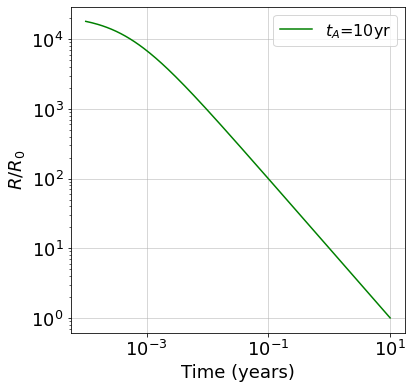

In [4]:
### Plot aftershock decay

# parameters
dS = 10.0 # non-dimensional units
tA = 10.0 # years

# times in years
tt = np.logspace(-4,1,201)

# normalized rate
rt = 1.0 / (np.exp(-dS)+tt/tA)

# plot setup
fig, axi = plt.subplots(1,1,figsize=(6,6))

# plot data
axi.loglog(tt,rt,'-g',label="$t_A$=10yr")

# label
axi.set_xlabel("Time (years)",fontsize=18)
axi.set_ylabel("$R/R_0$",fontsize=18)
axi.grid(lw=0.5)
axi.legend(loc="upper right",fontsize=16)
axi.tick_params(labelsize=18)

# show
plt.show()
plt.close()

---

Note that in our derivation above, we neglected the the $dS$ term in the state evolution. Had we not, the math is messier, but the same basic result holds and the curve would flatten out as $t \rightarrow t_A$.

---

The formula for $t_A$ makes some intuitive sense. If the background stressing rate is high, the aftershock sequence doesn't decay for very long before seismicity returns to the background. Alternatively, for earthquakes that occur in areas of low background stressing rate, the aftershock sequence can be quite extended.

In the real earth, we see aftershock sequences spanning durations that range from days to centuries. A famous example of the latter is M8 Nobi Japan earthquake of 1891, which had recorded aftershocks into the 1970s:

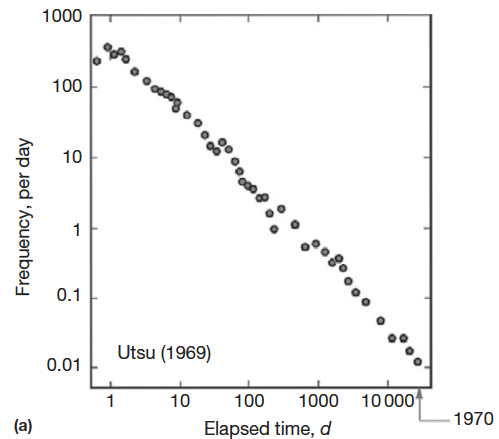

**Question**: What physical environments or tectonic regimes would you expect aftershock sequences to have particularly long or short durations?

---

Our aftershock formula we derived above can be rewritten in the form of the famous Omori's Law:

\begin{equation}
R(t) = \frac{c_1}{c_2 + t},
\end{equation}

with

\begin{equation}
c_1 = \frac{r_0 a \sigma}{\dot{S}_0}
\end{equation}

and

\begin{equation}
c_2 = \frac{r_0 a \sigma}{\dot{S}_0} \exp(-\Delta S / a \sigma).
\end{equation}

Thus, the rate-state seismicity model is consistent with the most ubiquitous observational constraint on earthquake triggering, which is always a good sign. 

Note that the formulation we have presented here has neglected other complicating factors like secondary triggering, geometric complexity, changes in normal stress and other time-dependent relaxation mechanisms.

# HOMEWORK

## Problem 1: More on Static Stress Changes

**Problem 1(a)**

The exercise above was for a $M$2 earthquake, where we saw that static stresses decay to ~ 10 kPa at about 200 m distance. Try again for earthquakes of magnitude M0 and M4, being careful to adjust the grid size (xmin and xmax) appropriately. What do you notice about the relationship between magnitude and the distance to the 10 kPa stress contour?

<font color='blue'>

**ANSWER**

For every two-unit jump in $M$, the stress contour moves out by a factor of 10. So the 10 kPa contour is at 20 m for a M0 and 2000 m for a M4. This is because the rupture length scales in this same way (10x jump in length for every 2 magnitude units).
    
</font>

M0.0, length = 6.3m
Calculating, please wait...
Done with point 100/400
Done with point 200/400
Done with point 300/400
Done with point 400/400
Done with all calculations


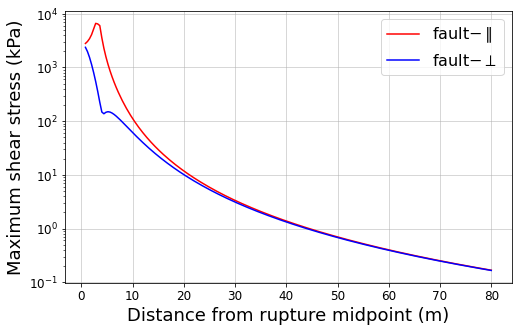

In [5]:
### M0 Earthquake Example

# import this package
from okada_wrapper import dc3dwrapper

# source parameters
mag = 0.0 # magnitude
delsig = 3.e6 # stress drop, Pa
mu = 3.e10 # shear modulus, Pa
lam = mu # lame parameter
source_depth = 8000. # fault depth, meters - here more positive is deeper
dip = 90. # fault dip, degrees
rake = -180. # 0 = left-lateral, 90 = reverse, 180 = right-lateral, -90 = normal

# define domain size (m)
xmin, xmax = -80., 80.
npts = 401

# compute moment in N-m (Aki and Richards, 2002)
moment = 10.**(1.5*mag+9.1)

# compute fault length, meters (square rupture) - see Gomberg et al., 2016
length = (3*np.pi/16 * moment/delsig)**(1./3.)
print("M{:}, length = {:.1f}m".format(mag,length))

# compute fault slip, meters
slip = moment / (mu*length**2);

# alpha parameter
alpha = (lam + mu) / (lam + 2*mu);

# dislocation vector
dislocation = slip*np.array(
    [np.cos(rake*(np.pi/180.)),
     np.sin(rake*(np.pi/180.)),
    0])

# observation depth
obs_depth = source_depth

# define grid to make calculations
x = np.linspace(xmin, xmax, npts)
y = np.linspace(xmin, xmax, npts)
ux = np.zeros((npts, npts))
uy = np.zeros((npts, npts))
uz = np.zeros((npts, npts))

# maximum shear stress
shear_grid = np.zeros((npts, npts))

# loop over grid
print("Calculating, please wait...")
for i in range(npts):
    
    # track progress
    if np.mod(i+1,100)==0:
        print("Done with point %d/%d" %(i+1,npts-1))
    
    # inner grid
    for j in range(npts):

        # calculate strain
        success, _, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the observation depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-length/2., length/2.], [-length/2., length/2.], # a square dislocation
            dislocation)          # strike-slip

        # check to see it worked
        assert(success == 0)
        
        # strain tensor
        strain = 0.5*(grad_u + grad_u.T)
               
        # Hooke's law gives the stress tensor
        stress = lam*np.sum(np.diag(strain))*np.eye(3) + 2*mu*strain
        
        # get principal stresses
        sigmas = np.linalg.eigvals(stress);
        S1, S2, S3 = sigmas[0], sigmas[1], sigmas[2]
        
        # max shear in kPa
        shear_grid[i,j] = np.abs(S1-S3)/ 2 / 1.e3;
        
print("Done with all calculations")

### Plot cross section

# find center of the rupture
imid = 1 + int((npts-1)/2)

# figure setup
fig, axi = plt.subplots(figsize=(8,5))

# plot cross-section
axi.semilogy(x[imid+1:],shear_grid[imid+1:,imid],'-r',label="fault$-\parallel$")
axi.semilogy(x[imid+1:],shear_grid[imid,imid+1:],'-b',label="fault$-\perp$")

# formatting
axi.set_xlabel('Distance from rupture midpoint (m)',fontsize=18);
axi.set_ylabel('Maximum shear stress (kPa)', fontsize=18)
axi.grid(lw=0.5)
axi.tick_params(labelsize=12)
axi.legend(loc="upper right",fontsize=16)

# show results
plt.show()
plt.close()

M2.0, length = 62.8m
Calculating, please wait...
Done with point 100/400
Done with point 200/400
Done with point 300/400
Done with point 400/400
Done with all calculations


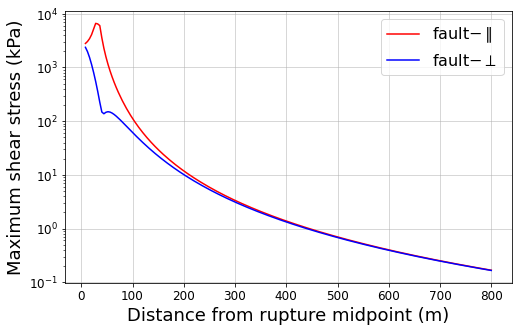

In [6]:
### M2 Earthquake Example

# import this package
from okada_wrapper import dc3dwrapper

# source parameters
mag = 2.0 # magnitude
delsig = 3.e6 # stress drop, Pa
mu = 3.e10 # shear modulus, Pa
lam = mu # lame parameter
source_depth = 8000. # fault depth, meters - here more positive is deeper
dip = 90. # fault dip, degrees
rake = -180. # 0 = left-lateral, 90 = reverse, 180 = right-lateral, -90 = normal

# define domain size (m)
xmin, xmax = -800., 800.
npts = 401

# compute moment in N-m (Aki and Richards, 2002)
moment = 10.**(1.5*mag+9.1)

# compute fault length, meters (square rupture) - see Gomberg et al., 2016
length = (3*np.pi/16 * moment/delsig)**(1./3.)
print("M{:}, length = {:.1f}m".format(mag,length))

# compute fault slip, meters
slip = moment / (mu*length**2);

# alpha parameter
alpha = (lam + mu) / (lam + 2*mu);

# dislocation vector
dislocation = slip*np.array(
    [np.cos(rake*(np.pi/180.)),
     np.sin(rake*(np.pi/180.)),
    0])

# observation depth
obs_depth = source_depth

# define grid to make calculations
x = np.linspace(xmin, xmax, npts)
y = np.linspace(xmin, xmax, npts)
ux = np.zeros((npts, npts))
uy = np.zeros((npts, npts))
uz = np.zeros((npts, npts))

# maximum shear stress
shear_grid = np.zeros((npts, npts))

# loop over grid
print("Calculating, please wait...")
for i in range(npts):
    
    # track progress
    if np.mod(i+1,100)==0:
        print("Done with point %d/%d" %(i+1,npts-1))
    
    # inner grid
    for j in range(npts):

        # calculate strain
        success, _, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the observation depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-length/2., length/2.], [-length/2., length/2.], # a square dislocation
            dislocation)          # strike-slip

        # check to see it worked
        assert(success == 0)
        
        # strain tensor
        strain = 0.5*(grad_u + grad_u.T)
               
        # Hooke's law gives the stress tensor
        stress = lam*np.sum(np.diag(strain))*np.eye(3) + 2*mu*strain
        
        # get principal stresses
        sigmas = np.linalg.eigvals(stress);
        S1, S2, S3 = sigmas[0], sigmas[1], sigmas[2]
        
        # max shear in kPa
        shear_grid[i,j] = np.abs(S1-S3)/ 2 / 1.e3;
        
print("Done with all calculations")

### Plot cross section

# find center of the rupture
imid = 1 + int((npts-1)/2)

# figure setup
fig, axi = plt.subplots(figsize=(8,5))

# plot cross-section
axi.semilogy(x[imid+1:],shear_grid[imid+1:,imid],'-r',label="fault$-\parallel$")
axi.semilogy(x[imid+1:],shear_grid[imid,imid+1:],'-b',label="fault$-\perp$")

# formatting
axi.set_xlabel('Distance from rupture midpoint (m)',fontsize=18);
axi.set_ylabel('Maximum shear stress (kPa)', fontsize=18)
axi.grid(lw=0.5)
axi.tick_params(labelsize=12)
axi.legend(loc="upper right",fontsize=16)

# show results
plt.show()
plt.close()

M4.0, length = 627.6m
Calculating, please wait...
Done with point 100/400
Done with point 200/400
Done with point 300/400
Done with point 400/400
Done with all calculations


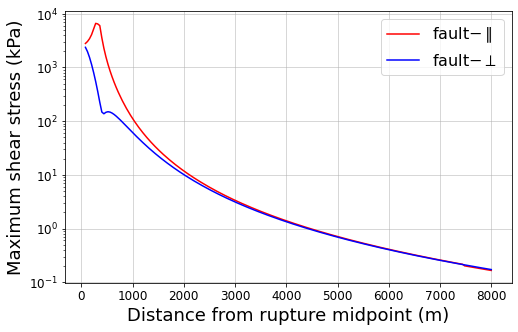

In [8]:
### M4 Earthquake Example

# import this package
from okada_wrapper import dc3dwrapper

# source parameters
mag = 4.0 # magnitude
delsig = 3.e6 # stress drop, Pa
mu = 3.e10 # shear modulus, Pa
lam = mu # lame parameter
source_depth = 8000. # fault depth, meters - here more positive is deeper
dip = 90. # fault dip, degrees
rake = -180. # 0 = left-lateral, 90 = reverse, 180 = right-lateral, -90 = normal

# define domain size (m)
xmin, xmax = -8000., 8000.
npts = 401

# compute moment in N-m (Aki and Richards, 2002)
moment = 10.**(1.5*mag+9.1)

# compute fault length, meters (square rupture) - see Gomberg et al., 2016
length = (3*np.pi/16 * moment/delsig)**(1./3.)
print("M{:}, length = {:.1f}m".format(mag,length))

# compute fault slip, meters
slip = moment / (mu*length**2);

# alpha parameter
alpha = (lam + mu) / (lam + 2*mu);

# dislocation vector
dislocation = slip*np.array(
    [np.cos(rake*(np.pi/180.)),
     np.sin(rake*(np.pi/180.)),
    0])

# observation depth
obs_depth = source_depth

# define grid to make calculations
x = np.linspace(xmin, xmax, npts)
y = np.linspace(xmin, xmax, npts)
ux = np.zeros((npts, npts))
uy = np.zeros((npts, npts))
uz = np.zeros((npts, npts))

# maximum shear stress
shear_grid = np.zeros((npts, npts))

# loop over grid
print("Calculating, please wait...")
for i in range(npts):
    
    # track progress
    if np.mod(i+1,100)==0:
        print("Done with point %d/%d" %(i+1,npts-1))
    
    # inner grid
    for j in range(npts):

        # calculate strain
        success, _, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the observation depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-length/2., length/2.], [-length/2., length/2.], # a square dislocation
            dislocation)          # strike-slip

        # check to see it worked
        assert(success == 0)
        
        # strain tensor
        strain = 0.5*(grad_u + grad_u.T)
               
        # Hooke's law gives the stress tensor
        stress = lam*np.sum(np.diag(strain))*np.eye(3) + 2*mu*strain
        
        # get principal stresses
        sigmas = np.linalg.eigvals(stress);
        S1, S2, S3 = sigmas[0], sigmas[1], sigmas[2]
        
        # max shear in kPa
        shear_grid[i,j] = np.abs(S1-S3)/ 2 / 1.e3;
        
print("Done with all calculations")

### Plot cross section

# find center of the rupture
imid = 1 + int((npts-1)/2)

# figure setup
fig, axi = plt.subplots(figsize=(8,5))

# plot cross-section
axi.semilogy(x[imid+1:],shear_grid[imid+1:,imid],'-r',label="fault$-\parallel$")
axi.semilogy(x[imid+1:],shear_grid[imid,imid+1:],'-b',label="fault$-\perp$")

# formatting
axi.set_xlabel('Distance from rupture midpoint (m)',fontsize=18);
axi.set_ylabel('Maximum shear stress (kPa)', fontsize=18)
axi.grid(lw=0.5)
axi.tick_params(labelsize=12)
axi.legend(loc="upper right",fontsize=16)

# show results
plt.show()
plt.close()

**Problem 1(b)**

Based on these plots, how do static stresses decay with distance from the rupture? (E.g., $1/r$, $1/r^2$, $1/r^3$, etc.). 

How might this compare to the decay of dynamic stresses with distance? 

[Hint: when thinking about dynamic stresses, how fast do body wave and surface wave amplitudes decay with distance? You may assume strain decays in a simalar fashion, see Problem 2].

<font color='blue'>

**ANSWER**

For static stresses, we can look at a log-log plot (see below). In the near field of the rupture, the falloff is somewhere between $1/r$ and $1/r^2$. Moving to the far field, stress falls off as $1/r^3$. 
    
Dynamic stresses falloff much less rapidly, less than $1/r$. See Cotton and Coutant (GJI 1997) for a numerical benchmarking of this.
    
</font>

M4.0, length = 627.6m
Calculating, please wait...
Done with point 100/400
Done with point 200/400
Done with point 300/400
Done with point 400/400
Done with all calculations


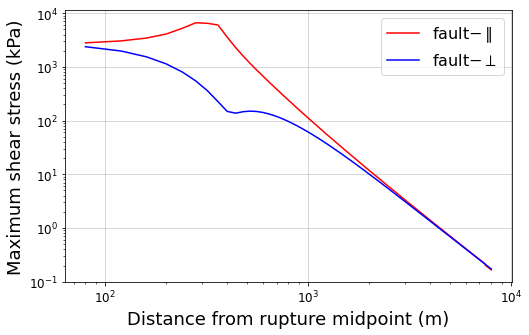

In [9]:
### M4 Earthquake Example, Log-Log

# import this package
from okada_wrapper import dc3dwrapper

# source parameters
mag = 4.0 # magnitude
delsig = 3.e6 # stress drop, Pa
mu = 3.e10 # shear modulus, Pa
lam = mu # lame parameter
source_depth = 8000. # fault depth, meters - here more positive is deeper
dip = 90. # fault dip, degrees
rake = -180. # 0 = left-lateral, 90 = reverse, 180 = right-lateral, -90 = normal

# define domain size (m)
xmin, xmax = -8000., 8000.
npts = 401

# compute moment in N-m (Aki and Richards, 2002)
moment = 10.**(1.5*mag+9.1)

# compute fault length, meters (square rupture) - see Gomberg et al., 2016
length = (3*np.pi/16 * moment/delsig)**(1./3.)
print("M{:}, length = {:.1f}m".format(mag,length))

# compute fault slip, meters
slip = moment / (mu*length**2);

# alpha parameter
alpha = (lam + mu) / (lam + 2*mu);

# dislocation vector
dislocation = slip*np.array(
    [np.cos(rake*(np.pi/180.)),
     np.sin(rake*(np.pi/180.)),
    0])

# observation depth
obs_depth = source_depth

# define grid to make calculations
x = np.linspace(xmin, xmax, npts)
y = np.linspace(xmin, xmax, npts)
ux = np.zeros((npts, npts))
uy = np.zeros((npts, npts))
uz = np.zeros((npts, npts))

# maximum shear stress
shear_grid = np.zeros((npts, npts))

# loop over grid
print("Calculating, please wait...")
for i in range(npts):
    
    # track progress
    if np.mod(i+1,100)==0:
        print("Done with point %d/%d" %(i+1,npts-1))
    
    # inner grid
    for j in range(npts):

        # calculate strain
        success, _, grad_u = dc3dwrapper(
            alpha,                    # (lam+mu)/(lam+2*mu)
            [x[i], y[j], -obs_depth], # note: the observation depth needs to be negative
            source_depth, dip,        # oddly, the source depth is positive
            [-length/2., length/2.], [-length/2., length/2.], # a square dislocation
            dislocation)          # strike-slip

        # check to see it worked
        assert(success == 0)
        
        # strain tensor
        strain = 0.5*(grad_u + grad_u.T)
               
        # Hooke's law gives the stress tensor
        stress = lam*np.sum(np.diag(strain))*np.eye(3) + 2*mu*strain
        
        # get principal stresses
        sigmas = np.linalg.eigvals(stress);
        S1, S2, S3 = sigmas[0], sigmas[1], sigmas[2]
        
        # max shear in kPa
        shear_grid[i,j] = np.abs(S1-S3)/ 2 / 1.e3;
        
print("Done with all calculations")

### Plot cross section

# find center of the rupture
imid = 1 + int((npts-1)/2)

# figure setup
fig, axi = plt.subplots(figsize=(8,5))

# plot cross-section
axi.loglog(x[imid+1:],shear_grid[imid+1:,imid],'-r',label="fault$-\parallel$")
axi.loglog(x[imid+1:],shear_grid[imid,imid+1:],'-b',label="fault$-\perp$")

# formatting
axi.set_xlabel('Distance from rupture midpoint (m)',fontsize=18);
axi.set_ylabel('Maximum shear stress (kPa)', fontsize=18)
axi.grid(lw=0.5)
axi.tick_params(labelsize=12)
axi.legend(loc="upper right",fontsize=16)

# show results
plt.show()
plt.close()

**Problem 1(c)**

In the example above, we calculated the maximum shear stress at each grid point. If we were interested instead in calculating Coulomb stress changes, what additional information would we need to know, and how would we do it?

[No need for an actual implementation here, just discuss the basic workflow you would follow].

<font color='blue'>

**ANSWER**

We would need to know or assume the fault orientation of the receiver faults in question. Then we could resolve shear and normal components using the full stress tensor, and compute Coulomb stress. This would also require some assumptions about the effective coefficient of friction.

</font>

## Problem 2: Dynamic Strain

As we saw above, in the far-field of large earthquakes static stresses become neglible, and the only viable triggering mechanism comes from dynamic stresses.

A decent approximation for the peak dynamic strain observed at a station is

\begin{equation}
e_{dyn} \sim PGV \, / \, c,
\end{equation}

where PGV is the peak ground velocity and c is the wavespeed. 

---
**Problem 2(a)**

For this exercise, visit the USGS Earthquakes webpage (https://www.usgs.gov/natural-hazards/earthquake-hazards/earthquakes) and find an earthquake of interest. If you are unsure, the "Significant Earthquake Archive" (https://earthquake.usgs.gov/earthquakes/browse/significant.php) is a good place to start.

Once you have picked an earthquake, navigate to the ShakeMap tab, and click on PGV. Imbed a screenshot of this image in the cell below. [You should be able to copy and paste and image or screenshot into Jupyter cells of type Markdown].

<font color='blue'>

**ANSWER**

Here, I will study the 2020 M5.7 Magna, Utah earthquake.

</font>

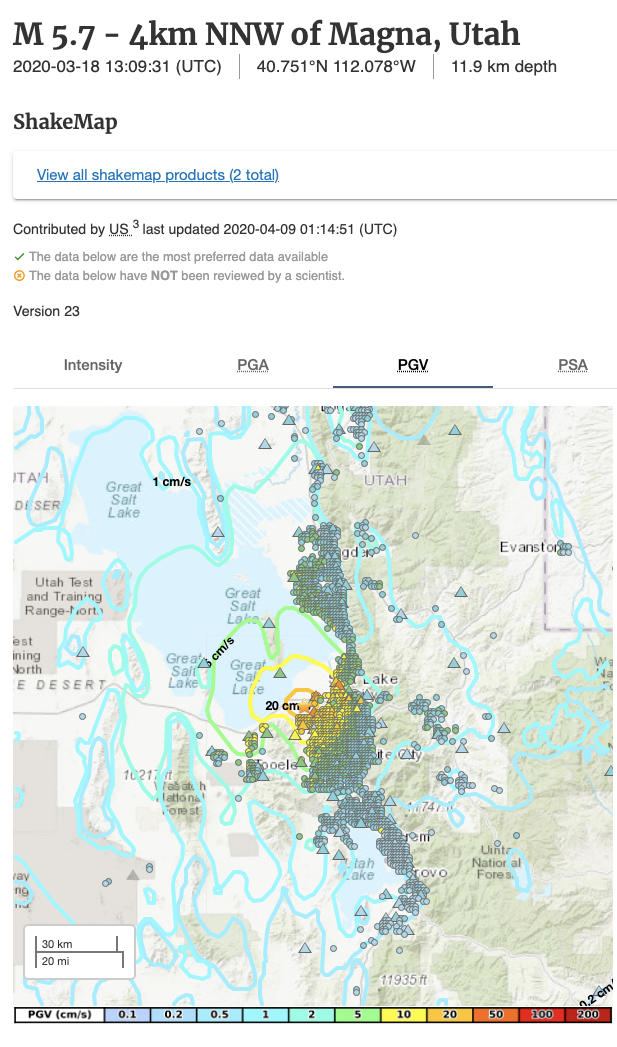

**Problem 2(b)**

Given observed PGV contours, calculate peak dynamic strains at a range of distances, and convert these to stress. About how far do you have to get from the earthquake for these values to exceed static stresses? 

<font color='blue'>

**ANSWER**

The map above has visible PGV contours of 20 cm/s, 10 cm/s, 5 cm/s, 2 cm/s, 1 cm/s. The contours are highly asymmetric because of directivity and/or amplification effects.
    
Dynamic strains scale as $PGV/c_s$. Taking $c_s$ to be 3 km/s, we see peak values of strain of order 67 microstrain, implying shear stress in the MPa range. Of course, the PGV values may be accentuated by surface effects, so this is not quite what we'd see at depth. Still, dynamic stresses are likely to be comparable to static in the very near field, and substantially greater in the far field (> ~30km away for an earthquake of this size).

</font>

In [11]:
### Calculations

# parameters
c = 3.0e5 # wavespeed in cm/s
mu = 30.0e3 # shear modulus in kPa

# calculate strains and stress
strains, stresses = [], []
for pgv in [20.0, 10.0, 5.0, 2.0, 1.0]:
    strain = pgv/c
    stress = mu*strain
    print("PGV = {:2.0f} cm/s: strain = {:.1e}, stress = {:.2f} MPa".format(
        pgv, strain, stress))

PGV = 20 cm/s: strain = 6.7e-05, stress = 2.00 MPa
PGV = 10 cm/s: strain = 3.3e-05, stress = 1.00 MPa
PGV =  5 cm/s: strain = 1.7e-05, stress = 0.50 MPa
PGV =  2 cm/s: strain = 6.7e-06, stress = 0.20 MPa
PGV =  1 cm/s: strain = 3.3e-06, stress = 0.10 MPa
